# Лабораторная работа №3

In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

1. Написать программу, которая разделяет исходную выборку на обучающую и тестовую (training set, test set). Использовать стандартные функции (train_test_split и др. нельзя).

In [55]:
# Чтение данных из файла
data = pd.read_excel("Concrete_Data.xls")

# Размер обучающей выборки (например, 80% данных)
train_size = int(len(data) * 0.8)

# Перемешиваем индексы
indices = np.random.permutation(data.shape[0])

# Разделение на обучающую и тестовую выборку
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Создание обучающей и тестовой выборки
train_data, test_data = data.iloc[train_indices], data.iloc[test_indices]

# Сохранение обучающей и тестовой выборки в файлы CSV
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)
print(f'{train_data.columns}')


Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')


2. С использованием библиотеки scikit-learn обучить модель линейной регрессии по обучающей выборке

In [63]:
X_train = train_data.drop(columns=['Concrete compressive strength(MPa, megapascals) '])
y_train = train_data['Concrete compressive strength(MPa, megapascals) ']
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

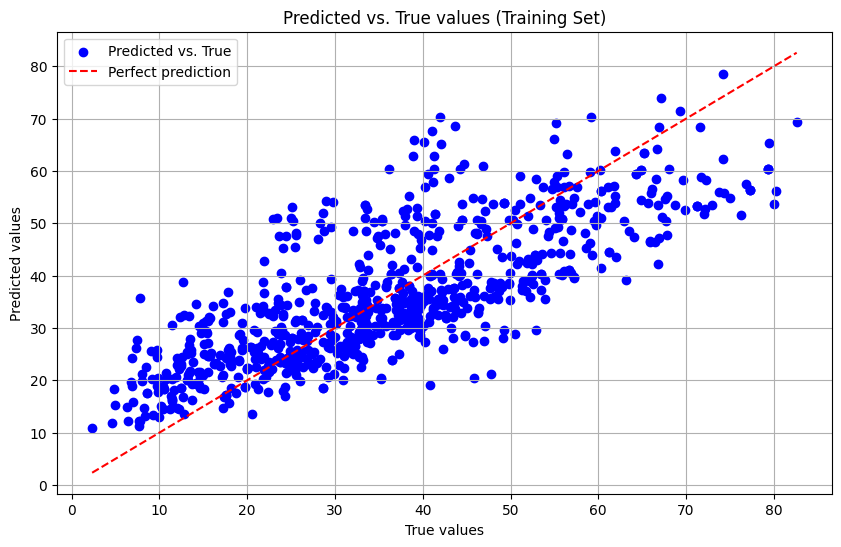

In [64]:
y_train_pred = model.predict(X_train)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Predicted vs. True')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect prediction')
plt.title('Predicted vs. True values (Training Set)')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)
plt.show()


3. Проверить точность модели по тестовой выборке

In [65]:
# Получение матрицы признаков и вектора целевой переменной для тестовой выборки
X_test = test_data.drop(columns=['Concrete compressive strength(MPa, megapascals) '])
y_test = test_data['Concrete compressive strength(MPa, megapascals) ']

# Предсказание значений целевой переменной на тестовой выборке
y_test_pred = model.predict(X_test)

# Оценка точности модели на тестовой выборке
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Среднеквадратическая ошибка (MSE) на тестовой выборке: {mse_test}")
print(f"Коэффициент детерминации (R-squared) на тестовой выборке: {r2_test}")



Среднеквадратическая ошибка (MSE) на тестовой выборке: 102.67164482617008
Коэффициент детерминации (R-squared) на тестовой выборке: 0.6471432867664013


4. Построить модель с использованием полиномиальной функции. Построить графики зависимости точности на обучающей и тестовой выборке от степени полиномиальной функции.

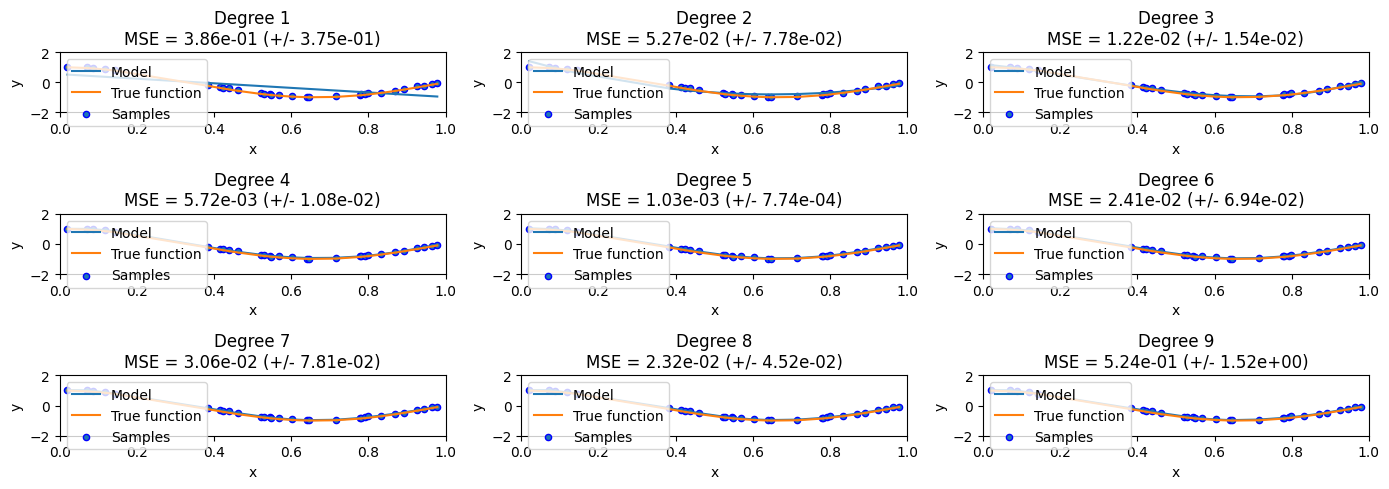

In [66]:
# Функция, представляющая истинную зависимость
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# Генерация случайных данных
np.random.seed(0)
n_samples = 30
degrees = range(1, 10)

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.rand(n_samples) * 0.1

plt.figure(figsize=(14, 5))

# Проход по разным степеням полинома
for i, degree in enumerate(degrees, 1):
    # Создание полиномиальных признаков и линейной регрессии
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression),
    ])

    # Обучение модели и оценка с использованием кросс-валидации
    scores = cross_val_score(pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)
    
    # Оценка на обучающем наборе данных
    pipeline.fit(X[:, np.newaxis], y)
    y_pred = pipeline.predict(X[:, np.newaxis])
    
    # Построение графика
    plt.subplot(3, 3, i)
    plt.plot(X, y_pred, label="Model")
    plt.plot(X, true_fun(X), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(f"Degree {degree}\nMSE = {-scores.mean():.2e} (+/- {scores.std():.2e})")

plt.tight_layout()
plt.show()

5. Построить модель с использованием регуляризации пример. На основе экспериментов подобрать параметры для регуляризации. Построить графики зависимости точности модели на обучающей и тестовой выборках от коэффициента регуляризации.

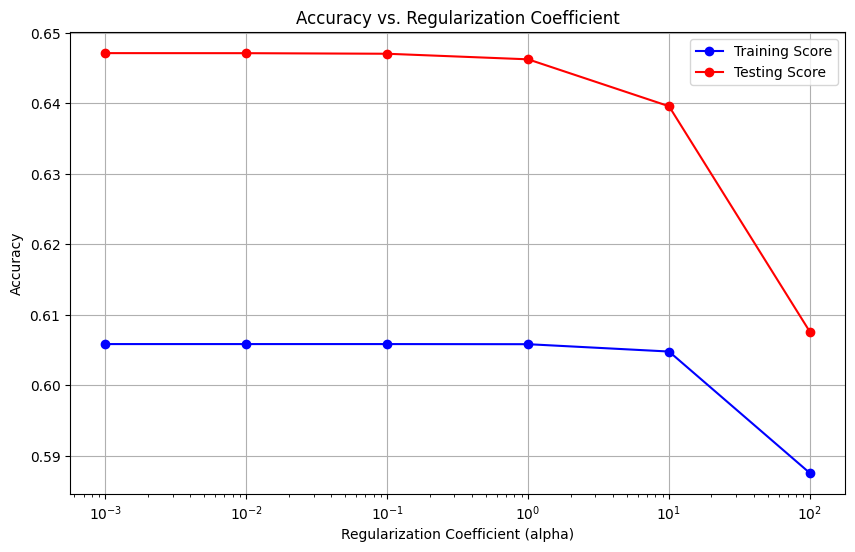

In [67]:
# Подготовка данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание списка значений параметра регуляризации
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Списки для сохранения точности моделей на обучающей и тестовой выборках
train_scores = []
test_scores = []

# Обучение моделей с разными значениями параметра регуляризации
for alpha in alphas:
    # Создание и обучение модели Ridge
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    
    # Оценка точности на обучающей выборке
    train_score = model.score(X_train_scaled, y_train)
    train_scores.append(train_score)
    
    # Оценка точности на тестовой выборке
    test_score = model.score(X_test_scaled, y_test)
    test_scores.append(test_score)

# Построение графиков зависимости точности от коэффициента регуляризации
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_scores, label='Training Score', marker='o', color='blue')
plt.plot(alphas, test_scores, label='Testing Score', marker='o', color='red')
plt.xlabel('Regularization Coefficient (alpha)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Regularization Coefficient')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()